In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Alzheimer MRI Disease Classification Dataset/README.md
/kaggle/input/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet
/kaggle/input/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet


In [3]:
import pandas as pd

# Correct file paths
train_path = "/kaggle/input/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet"
test_path = "/kaggle/input/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet"

# Load the datasets
train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

# Display first few rows
print("Train Data:")
display(train_df.head())

print("\nTest Data:")
display(test_df.head())


Train Data:


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2



Test Data:


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [4]:
print("Columns in Train Dataset:")
print(train_df.columns)

Columns in Train Dataset:
Index(['image', 'label'], dtype='object')


In [5]:
# Check unique class labels
print("Unique Labels in Train Dataset:")
print(train_df["label"].unique())

# Count instances per class
print("\nClass Distribution:")
print(train_df["label"].value_counts())

Unique Labels in Train Dataset:
[2 0 3 1]

Class Distribution:
label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64


In [6]:
# Display first few entries in the "image" column
print("First few image entries:")
print(train_df["image"].head())

First few image entries:
0    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
Name: image, dtype: object


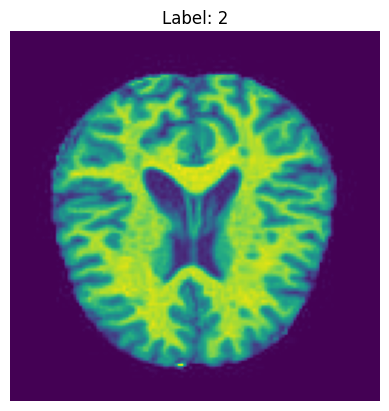

In [7]:
#Decode Image Data
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to decode image
def decode_image(image_data):
    return Image.open(io.BytesIO(image_data))

# Extract the first image
first_image_data = train_df["image"].iloc[0]['bytes']
first_image = decode_image(first_image_data)

# Display image
plt.imshow(first_image)
plt.axis("off")
plt.title(f"Label: {train_df['label'].iloc[0]}")
plt.show()

In [8]:
#convert all images to NumPy arrays for model training
import tensorflow as tf

# Function to process images
def preprocess_image(image_data):
    img = decode_image(image_data)  # Decode
    img = img.resize((128, 128))  # Resize
    img = np.array(img) / 255.0  # Normalize
    return img

# Apply transformation
X_train = np.array([preprocess_image(i['bytes']) for i in train_df["image"]])
y_train = np.array(train_df["label"])

X_test = np.array([preprocess_image(i['bytes']) for i in test_df["image"]])
y_test = np.array(test_df["label"])

print(f"Processed Train Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Processed Test Data: {X_test.shape}, Labels: {y_test.shape}")


Processed Train Data: (5120, 128, 128), Labels: (5120,)
Processed Test Data: (1280, 128, 128), Labels: (1280,)


In [9]:
#1️⃣ Split training data into training & validation sets
#2️⃣ Apply SMOTE to balance classes in the training set
from sklearn.model_selection import train_test_split

# Split into train and validation (80-20 split)
X_train_res, X_val, y_train_res, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"Train Set: {X_train_res.shape}, Labels: {y_train_res.shape}")
print(f"Validation Set: {X_val.shape}, Labels: {y_val.shape}")


Train Set: (4096, 128, 128), Labels: (4096,)
Validation Set: (1024, 128, 128), Labels: (1024,)


In [10]:
from imblearn.over_sampling import SMOTE

# Reshape for SMOTE (flatten images)
X_train_flat = X_train_res.reshape(X_train_res.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train_res)

# Reshape back to image format
X_train_balanced = X_train_balanced.reshape(-1, 128, 128)

print(f"Balanced Train Set: {X_train_balanced.shape}, Labels: {y_train_balanced.shape}")


Balanced Train Set: (8212, 128, 128), Labels: (8212,)


In [11]:
#One-Hot Encode Labels
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical (one-hot encoding)
y_train_balanced = to_categorical(y_train_balanced, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

print(f"One-Hot Encoded Labels: {y_train_balanced.shape}")


One-Hot Encoded Labels: (8212, 4)


In [12]:
#Build CNN Model with SE Blocks & Avg-TopK Pooling
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D, Multiply, Reshape

# Squeeze & Excitation Block
def se_block(input_tensor, ratio=16):
    """Squeeze & Excitation Block"""
    filters = input_tensor.shape[-1]
    
    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation="relu")(se)
    se = Dense(filters, activation="sigmoid")(se)
    
    # Excite: Scale feature maps
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

In [13]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer

class AvgTopKPooling(Layer):
    """Avg-TopK Pooling Layer"""
    def __init__(self, k=3, **kwargs):
        super(AvgTopKPooling, self).__init__(**kwargs)
        self.k = k

    def call(self, inputs):
        top_k, _ = tf.math.top_k(inputs, k=self.k, sorted=False)
        return K.mean(top_k, axis=-1)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Flatten, Dense, Dropout

# Define Deep CNN Model
def build_model(input_shape=(128, 128, 1), num_classes=4):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = se_block(x)

    # Block 2
    x = Conv2D(64, (3, 3), padding="same", strides=2)(x)  # Downsampling with stride
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = se_block(x)

    # Block 3
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = se_block(x)

    # Block 4
    x = Conv2D(256, (3, 3), padding="same", strides=2)(x)  # Another downsampling
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = se_block(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = se_block(x)
    
    # Avg-TopK Pooling
    x = AvgTopKPooling(k=3)(x)
    
    # Flatten & Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    
    # Output Layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model


In [15]:
#Compile & Train the Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Build model
model = build_model(input_shape=(128, 128, 1), num_classes=4)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", patience=10, factor=0.8, verbose=1, min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True, verbose=1
)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=15,  # Stop if no improvement for 15 epochs
    restore_best_weights=True,
    verbose=1
)

In [17]:
# Train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=200,
    callbacks=[lr_scheduler, checkpoint,early_stopping]
)


Epoch 1/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.2706 - loss: 1.5484
Epoch 1: val_loss improved from inf to 1.49368, saving model to best_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 69s 313ms/step - accuracy: 0.2709 - loss: 1.5471 - val_accuracy: 0.1416 - val_loss: 1.4937 - learning_rate: 0.0010
Epoch 2/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5218 - loss: 1.0030
Epoch 2: val_loss improved from 1.49368 to 1.37538, saving model to best_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.5222 - loss: 1.0022 - val_accuracy: 0.1416 - val_loss: 1.3754 - learning_rate: 0.0010
Epoch 3/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6494 - loss: 0.7175
Epoch 3: val_loss did not improve from 1.37538
129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.6495 - loss: 0.7173 - val_accuracy: 0.1416 - val_loss: 1.5931 - learning_rate: 0.0010
Epoch 4/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7057 - loss: 0.6153

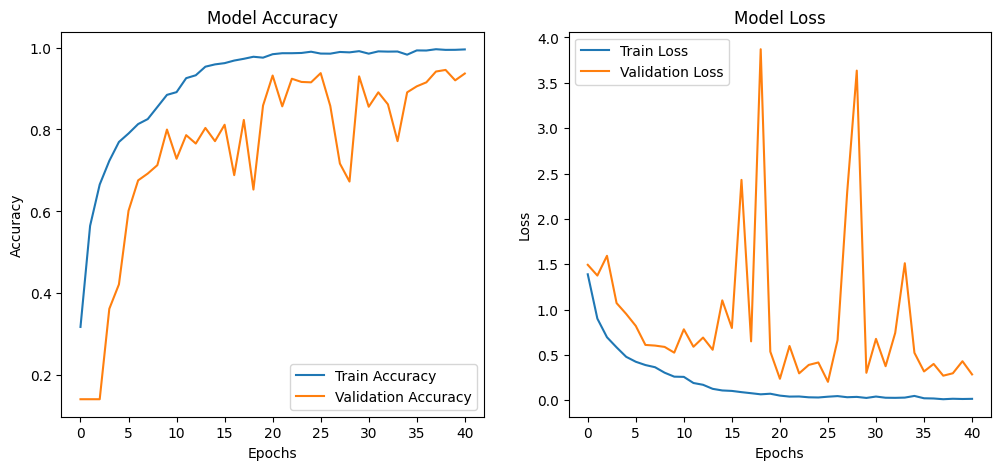

In [18]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
def plot_training(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    ax[0].plot(history.history["accuracy"], label="Train Accuracy")
    ax[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    ax[0].set_title("Model Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # Loss
    ax[1].plot(history.history["loss"], label="Train Loss")
    ax[1].plot(history.history["val_loss"], label="Validation Loss")
    ax[1].set_title("Model Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.show()

# Call the function
plot_training(history)

Final Training Accuracy: 99.54%
Final Validation Accuracy: 93.65%


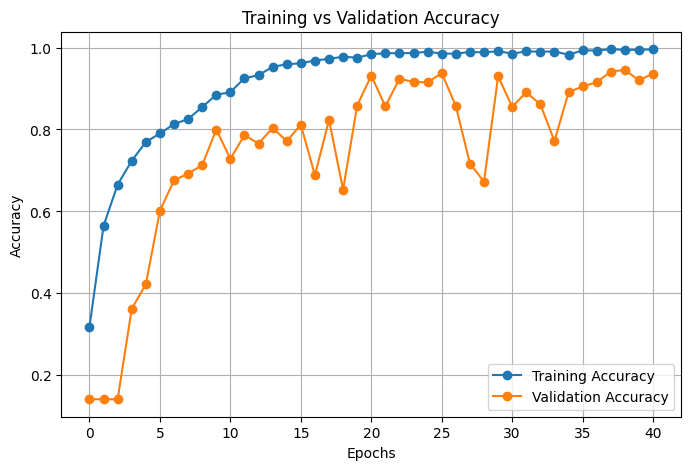

In [19]:
# Assuming 'history' is the object returned by model.fit()
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Print final accuracies
print(f"Final Training Accuracy: {train_acc[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc[-1] * 100:.2f}%")

# Plot Accuracy Graph
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


In [20]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9311 - loss: 0.3274

Test Accuracy: 93.44%
Test Loss: 0.2707


In [21]:
for layer in model.layers:
    print(layer.name)

input_layer
conv2d
batch_normalization
re_lu
global_average_pooling2d
dense
dense_1
reshape
multiply
conv2d_1
batch_normalization_1
re_lu_1
global_average_pooling2d_1
dense_2
dense_3
reshape_1
multiply_1
conv2d_2
batch_normalization_2
re_lu_2
global_average_pooling2d_2
dense_4
dense_5
reshape_2
multiply_2
conv2d_3
batch_normalization_3
re_lu_3
global_average_pooling2d_3
dense_6
dense_7
reshape_3
multiply_3
conv2d_4
batch_normalization_4
re_lu_4
global_average_pooling2d_4
dense_8
dense_9
reshape_4
multiply_4
avg_top_k_pooling
flatten
dense_10
dropout
dense_11
dropout_1
dense_12
dropout_2
dense_13


In [22]:
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer("conv2d_3").output, model.output]  # Use conv2d_3 instead
)



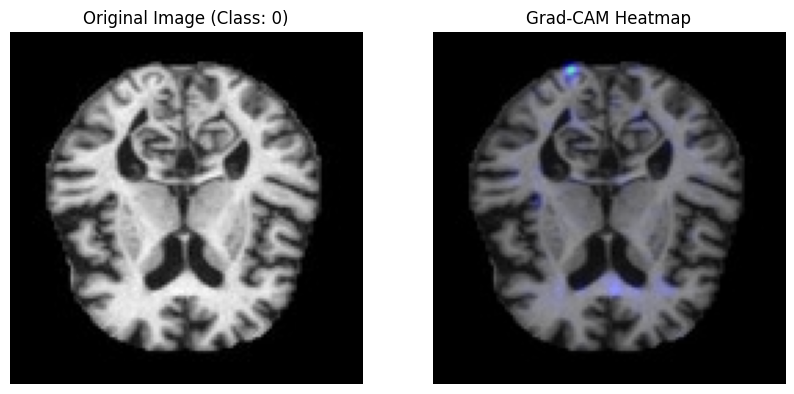

In [23]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to apply Grad-CAM
def grad_cam(model, image, label_index, layer_name="conv2d_10"):  # Change to a deeper Conv layer if needed
    """Generates a Grad-CAM heatmap for a given image."""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, label_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Remove negative values

    # **Normalize and enhance contrast**
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-10)
    heatmap = heatmap ** 4  # Increase intensity

    return heatmap

# Function to overlay heatmap on original image
def overlay_heatmap(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    # **Use COLORMAP_HOT for better visibility**
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    return overlay

# Pick a test image
sample_index = 10  # Change index to visualize different test images
sample_image = X_test[sample_index]
sample_label = y_test[sample_index].argmax()

# Generate Grad-CAM heatmap using the correct conv2d layer
heatmap = grad_cam(model, sample_image, sample_label, layer_name="conv2d_3")


# Overlay heatmap on original image
sample_image_rgb = (sample_image * 255).astype(np.uint8)
sample_image_rgb = cv2.cvtColor(sample_image_rgb, cv2.COLOR_GRAY2RGB)
overlay_img = overlay_heatmap(sample_image_rgb, heatmap)

# Show result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.title(f"Original Image (Class: {sample_label})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_img)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.show()


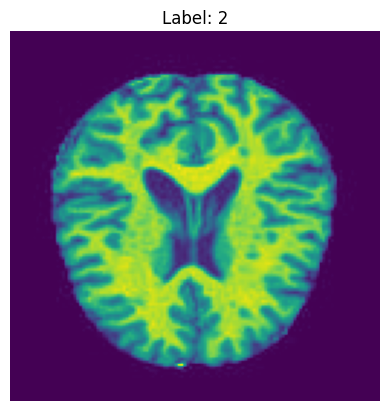

Image shape: (128, 128)


In [24]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to decode and process image
def load_image_as_numpy(image_data):
    img = Image.open(io.BytesIO(image_data))  # Decode image
    img = img.resize((128, 128))  # Resize
    img_array = np.array(img) / 255.0  # Normalize
    return img_array

# Extract the first image from the dataset
first_image_data = train_df["image"].iloc[0]['bytes']
first_image_array = load_image_as_numpy(first_image_data)

# Display image
plt.imshow(first_image_array)
plt.axis("off")
plt.title(f"Label: {train_df['label'].iloc[0]}")
plt.show()

# Print image shape
print("Image shape:", first_image_array.shape)


In [25]:
!pip install tf-keras-vis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.0 MB/s eta 0:00:00


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


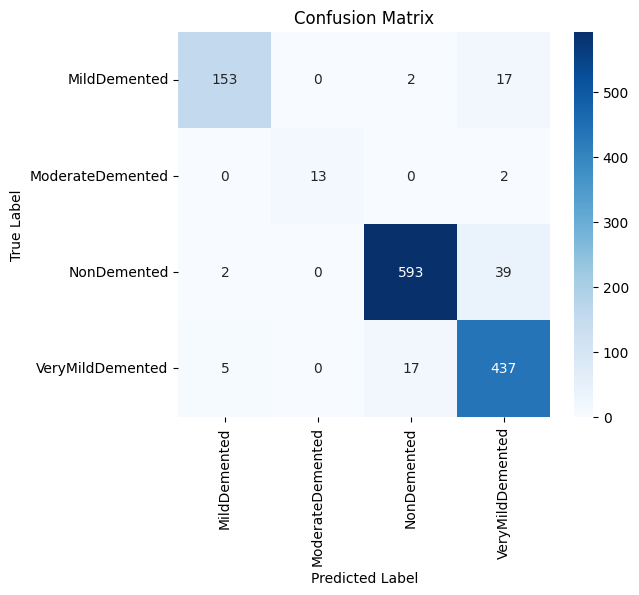

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.96      0.89      0.92       172
ModerateDemented       1.00      0.87      0.93        15
     NonDemented       0.97      0.94      0.95       634
VeryMildDemented       0.88      0.95      0.92       459

        accuracy                           0.93      1280
       macro avg       0.95      0.91      0.93      1280
    weighted avg       0.94      0.93      0.93      1280



In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
class_labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
# Get model predictions
y_pred_probs = model.predict(X_test)  # Get probability scores
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))
